# Regression Project - Zillow

Name: Craig Calzado

<h2>Goals</h2>

- Discover what is driving customer to churn.
- Create Machine learning classification models that can accuratly predict customer churn.
- Document the process for project replication.

<h2>Executive Summary</h2>
Discovery:

- There were four driver of churn internet service(Fiber), Payment(Electronic Check), Month to month contracts, and Tenure.
- Analysis showed that customers under a year of tenure were the most likley to churn.
- The Classification model predited the churn of customers at a 78% accuracy with a baseline of 73.5% accuracy.

Reccomendations:

- Offer incintves to move customers from month to month to a 1 or 2 year contract.
- Offer incintive to setup autopay.
- Target customer who have a tenure less then 12 months.
- Create surveys to check the integrety of the Fiber optic internet service.
- For customers on Fiber offer DSL until Fiber is stable.

<h2>Imports</h2>

In [1]:
# imports
# custom function imports
import wrangle
import f_engineer
import prepare
import project_models
# basic labraries
import pandas as pd
from scipy.stats import pearsonr, ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
# sklearn libraries
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import  mean_squared_error, explained_variance_score
# remove warnings
import warnings
warnings.filterwarnings('ignore')


<h2>Data Acquisition/Wrangle</h2>

In [2]:
# utilize wrangle.py to load data
df = wrangle.get_zillow_project_data()
df.head() # check the first 5 rows of the data

Let me get that for you...


,parcelid,bathroomcnt,bedroomcnt,finishedsquarefeet12,fips,lotsizesquarefeet,yearbuilt,taxvaluedollarcnt,logerror,transactiondate,taxamount
0,12797413,2.0,4.0,1178.0,6037.0,6213.0,1951.0,223459.0,0.038661,2017-01-11,2864.03
1,10808520,3.0,3.0,2287.0,6037.0,10249.0,1978.0,753587.0,0.000974,2017-01-11,9115.66
2,12961285,5.0,5.0,3135.0,6037.0,11772.0,1951.0,2132481.0,1.457087,2017-01-11,24025.64
3,14195775,2.5,4.0,2990.0,6059.0,15300.0,1982.0,599991.0,0.066588,2017-01-11,7187.12
4,11243022,2.0,2.0,1080.0,6037.0,108228.0,1973.0,130028.0,-0.008227,2017-01-11,1559.50


<h2>Data Preparation</h2>

Dropped columns = ['Unnamed: 0', 'internet_service_type_id', 'payment_type_id', 'contract_type_id']. These columns held no intel value.

Created dummy columns of ['gender', 'payment_type', 'contract_type', 'internet_service_type']

- gender_Male = '0' is female, '1' is male
- payment_type = electronic check, mailed check, credit card( 0 is not automatic, 1 is automatic)
- contract_type = one year, two year
- internet_service_type = Fiber optic(0 is DSL, 1 is Fiber Optic), None

In [3]:
# Function that identifies the tax rate for each county from project_models.py
project_models.get_tax_rate(df)

Median tax rate for Los Angelos 1.27
Median tax rate for Onange 1.16
Median tax rate for Ventura 1.12


In [4]:
# prep the data for modeling and feature engineering
df = wrangle.zillow_proj_prep(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51834 entries, 0 to 52441
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        51834 non-null  float64
 1   bedrooms         51834 non-null  float64
 2   sqft             51834 non-null  float64
 3   county_fips      51834 non-null  float64
 4   lotsqft          51834 non-null  float64
 5   year             51834 non-null  float64
 6   value            51834 non-null  float64
 7   logerror         51834 non-null  float64
 8   transactiondate  51834 non-null  object 
dtypes: float64(8), object(1)
memory usage: 4.0+ MB


In [5]:
# check data for nulls
df.isnull().sum()

bathrooms          0
bedrooms           0
sqft               0
county_fips        0
lotsqft            0
year               0
value              0
logerror           0
transactiondate    0
dtype: int64

In [6]:
# remove outliers
df = prepare.remove_outliers_fips(df, 1.5)

<h3>Split the data into train, validate, test</h3>

In [7]:
# split the dataframe into train, validate, and test
train, validate, test = wrangle.split_dataframe(df)
print(train.shape)
print(validate.shape)
print(test.shape)

(22979, 9)
(9849, 9)
(8208, 9)


<h2>Data Exploration</h2>

- determinme the drivers of churn
- visulize the data
- run statistical test
- create a baseline model

In [8]:
# create sample of train dataset for easier visualization
train_sample = train.sample(n=1000)
# create a pairplot of the sampled train dataset
#sns.pairplot(train_sample, hue = ('value'))

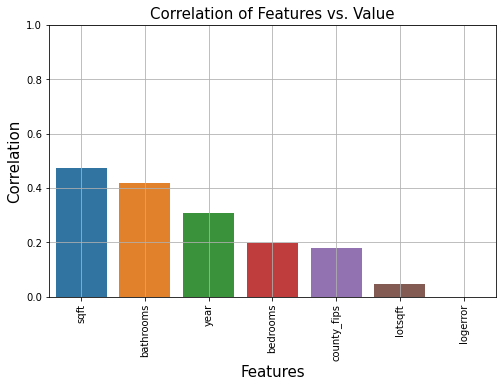

In [9]:
# correlation of all features vs. target
project_models.sample_corr(train_sample, 'value')

In [10]:
# Correlation tests are used to check if two features are correlated
# the closer the correlation is to 1, the more correlated the features are
project_models.pearson_corr(train, 'value')

sqft (0.427263143733718, 0.0)
bathrooms (0.3598203087567747, 0.0)
bedrooms (0.18537859998260434, 9.455186615396512e-177)
lotsqft (0.016693804514389884, 0.011386002192380194)


In [11]:
# t test are used to check if two features are statistically different
# the closer the p value is to 0, the more statistically significant the test
project_models.ttest_corr(train, 'value')

sqft Ttest_indResult(statistic=232.03387068459054, pvalue=0.0)
bathrooms Ttest_indResult(statistic=233.10299463400494, pvalue=0.0)
bedrooms Ttest_indResult(statistic=233.10226494673805, pvalue=0.0)
lotsqft Ttest_indResult(statistic=228.81637038310328, pvalue=0.0)


In [12]:
# function that creates your X and y dataframes
X_train, y_train, X_validate, y_validate, X_test, y_test = project_models.create_X_y(train, validate, test)
# check the shape of the X and y dataframes
print('Shape of X_train is', X_train.shape)
print('Shape of y_train is', y_train.shape)
print('Shape of X_validate is', X_validate.shape)
print('Shape of y_validate is', y_validate.shape)
print('Shape of X_test is', X_test.shape)


Shape of X_train is (22979, 5)
Shape of y_train is (22979,)
Shape of X_validate is (9849, 5)
Shape of y_validate is (9849,)
Shape of X_test is (8208, 5)


In [13]:
# scale your X_train, X_validate, and X_test dataframes
X_train_scaled, X_validate_scaled, X_test_scaled = project_models.scale_X(X_train, X_validate, X_test)
# check the shape of the scaled X dataframes
print('Shape of X_train_scaled is', X_train_scaled.shape)
print('Shape of X_validate_scaled is', X_validate_scaled.shape)
print('Shape of X_test_scaled is', X_test_scaled.shape)

Shape of X_train_scaled is (22979, 5)
Shape of X_validate_scaled is (9849, 5)
Shape of X_test_scaled is (8208, 5)


In [14]:
# kbest function for X_train and y_train
project_models.kbest_X_y(X_train, y_train)

Index(['bathrooms', 'sqft', 'year'], dtype='object')
                       p            f
bathrooms   0.000000e+00  3417.285410
bedrooms   9.455187e-177   817.710591
sqft        0.000000e+00  5131.271628
lotsqft     1.138600e-02     6.405087
year       1.201392e-302  1425.193007 None


In [15]:
# Progressively eliminate features based on importance to the model using rfe
project_models.rfe(X_train, y_train)


(['bathrooms', 'bedrooms', 'year'],
          Var  Rank
 0  bathrooms     1
 1   bedrooms     1
 4       year     1
 2       sqft     2
 3    lotsqft     3)

In [16]:
# convert y to a dataframe
y_train, y_validate, y_test = project_models.y_dataframe(y_train, y_validate, y_test)

In [17]:
# create median baseline
y_train, y_validate, y_test = project_models.median_baseline(y_train, y_validate, y_test)
print(y_train.head())

          value  price_pred_median
31495  482254.0           328336.0
29824  711516.0           328336.0
41480  299124.0           328336.0
8979   127120.0           328336.0
2019   629603.0           328336.0


RMSE using Median
Train/In-Sample:  236525.22 
Validate/Out-of-Sample:  238483.92 
 
 R^2 using Mean
Train/In-Sample:  -0.0 
Validate/Out-of-Sample:  0.0


(None, <AxesSubplot:xlabel='value', ylabel='price_pred_median'>)

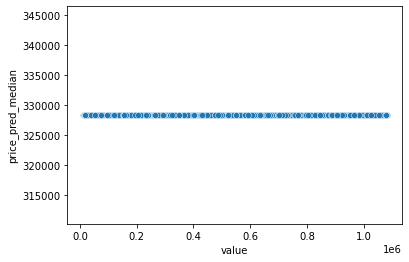

In [18]:
# function of the RMSE and R^2
project_models.rmse_r2(y_train, y_validate, y_test)

RMSE for OLS using LinearRegression
Training/In-Sample:  209068.38 
Validation/Out-of-Sample:  210201.45 
 
 R^2 using Mean
Train/In-Sample:  0.2 
Validate/Out-of-Sample:  0.2


(None, <AxesSubplot:xlabel='value', ylabel='price_pred_lm'>)

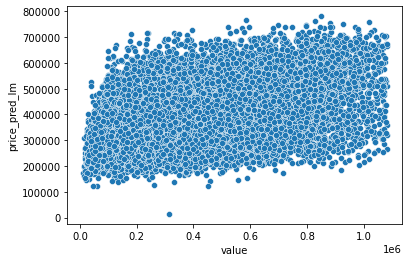

In [19]:
# function of the Linear regression, OLS
project_models.lm_ols(X_train, y_train, X_validate, y_validate)

RMSE for Lasso + Lars
Training/In-Sample:  209068.77 
Validation/Out-of-Sample:  210198.45 
 
 R^2 using Mean
Train/In-Sample:  0.2 
Validate/Out-of-Sample:  0.2


(None, <AxesSubplot:xlabel='value', ylabel='price_pred_lars'>)

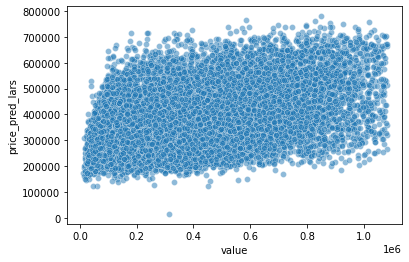

In [20]:
# function of the Lars Lasso Regression
project_models.lars_lasso(X_train, y_train, X_validate, y_validate, X_test, y_test)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  234345.63 
Validation/Out-of-Sample:  235581.17 
 
 R^2 using Mean
Train/In-Sample:  0.0 
Validate/Out-of-Sample:  0.0


(None,
 <AxesSubplot:xlabel='value', ylabel='price_pred_glm'>,
 <AxesSubplot:xlabel='value', ylabel='price_pred_glm'>)

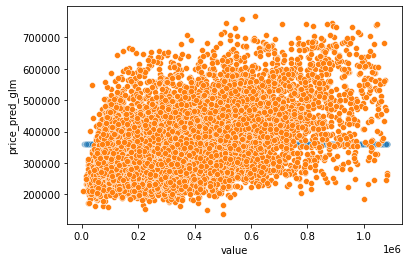

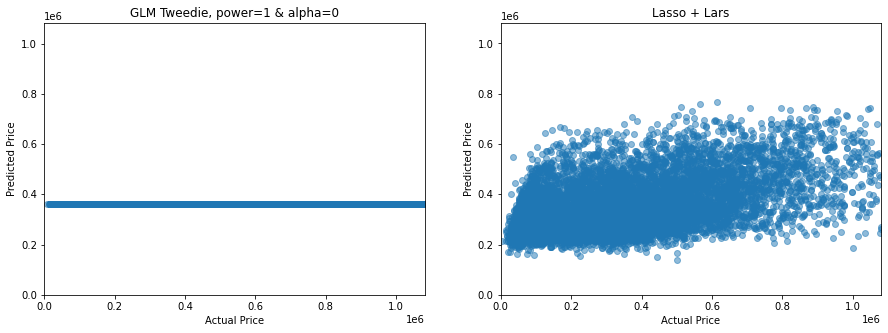

In [21]:
# Function of the Tweedie regression
project_models.glm_tweedie(X_train, y_train, X_validate, y_validate, X_test, y_test)

RMSE for Lasso + Lars
 Test/Out-of-Sample:  208614.82 
 
 R^2 using Mean
 Test/Out-of-Sample:  0.22


(None, <AxesSubplot:xlabel='value', ylabel='price_pred_lars'>)

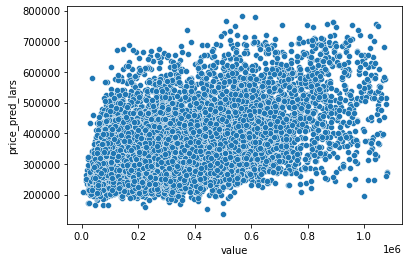

In [22]:
# Function that predicts test data
project_models.lars_test(X_test, y_test)

The three most predictive features for tax value are: area, bedroom, bathroom.

LassaLars was best model as determined by RMSE and R^2.

County had an effect on tax value, but was not one of the most important drivers.